In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from datetime import date, datetime

from sklearn.metrics import confusion_matrix
from sklearn.metrics import normalized_mutual_info_score, mutual_info_score
from sklearn.feature_selection import mutual_info_regression

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.linear_model import LinearRegression

from sklearn.pipeline import Pipeline

from matplotlib import colors
import seaborn as sns


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers

In [2]:
sns.set_style("whitegrid")

In [3]:
str_state = 'GA'
file = 'agent_comments_sales_'+str_state


In [4]:
df_sales_predictors = pd.read_feather(file + '_model03.fea') 
df_Predictand = pd.read_feather(file + '_predictand2.fea') 

In [ ]:
df_Transprice = pd.read_feather(file + '_Transprice.fea') 

In [6]:
avmvalue = df_sales_predictors['avmValue']

In [7]:
avmvalue

0         405972.57
1         244827.67
2         229674.21
3         143607.40
4         408971.22
            ...    
534373    444373.18
534374    212083.67
534375    157484.07
534376    193862.59
534377    191104.55
Name: avmValue, Length: 534378, dtype: float64

In [13]:
df_sales_predictors = df_sales_predictors.drop(columns = 'avmValue')

In [14]:
predictor_array = df_sales_predictors.to_numpy()
#predictor_array = predictor_array[:, -3:]
transform_predictors = MinMaxScaler(feature_range=(-6, 6)).fit(predictor_array)
predictor_array_transformed = transform_predictors.transform(predictor_array)
#predictor_array_transformed2 = transform_predictors.transform(predictor_array)
#predictor_array_transformed = predictor_array

In [15]:
type(predictor_array_transformed)

numpy.ndarray

In [16]:
predictor_array.shape

(534378, 106)

In [17]:
print(len(df_sales_predictors.columns))

106


In [20]:
Predictand = df_Predictand['avmerror'].values

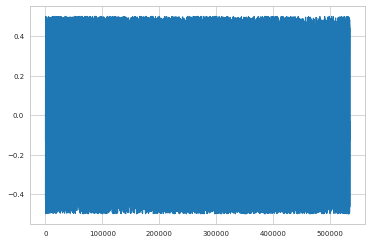

In [21]:
plt.plot(Predictand)

In [22]:
transform_predictand = MinMaxScaler(feature_range=(0, 1)).fit(Predictand.reshape(-1, 1))
Predictand_transformed = transform_predictand.transform(Predictand.reshape(-1, 1))

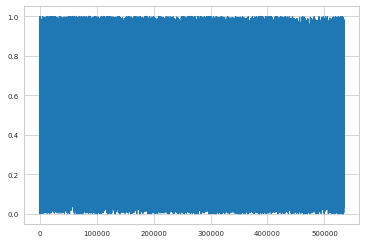

In [23]:
plt.plot(Predictand_transformed)

In [24]:

#cov_2 = np.dot (predictor_array_transformed, predictor_array_transformed.T)
#print(cov_2.shape)


In [25]:
predictor_array_transformed.shape

(534378, 106)

In [26]:
Predictand_transformed.shape

(534378, 1)

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
train_samples = 300_000  # Samples used for training the models
X_train, X_test, y_train, y_test = train_test_split(
    predictor_array_transformed,
    Predictand_transformed,
    shuffle=False,
    test_size=len(Predictand_transformed) - train_samples,
)

In [41]:
# Model definition

model_NN_Class = keras.Sequential()
model_NN_Class.add(keras.layers.Dense(60, activation='sigmoid', input_dim=106))
model_NN_Class.add(keras.layers.Dense(20, activation='sigmoid'))
model_NN_Class.add(keras.layers.Dense(1, activation='sigmoid', use_bias =True))


In [42]:
model_NN_Class.compile(loss='mse', optimizer='adam')

In [71]:
fit_history = model_NN_Class.fit(X_train, y_train, epochs=50, batch_size= 100)

Epoch 1/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 2/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 3/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 4/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0209
Epoch 5/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 6/50
3000/3000 [==============================] - 9s 3ms/step - loss: 0.0209
Epoch 7/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0208
Epoch 8/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0208
Epoch 9/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0208
Epoch 10/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0208
Epoch 11/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0.0208
Epoch 12/50
3000/3000 [==============================] - 10s 3ms/step - loss: 0

In [34]:
predictions = model_NN_Class.predict(X_train)

In [35]:
#predictions = (predictions - predictions.min())
#predictions = predictions/(predictions.max()) *2. -1

In [36]:
predictions.shape

(300000, 1)

In [37]:
y_train.shape

(300000, 1)

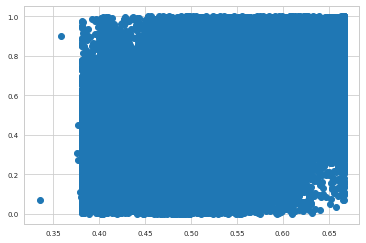

In [38]:
plt.plot(predictions.reshape(len(y_train)), y_train.reshape(len(y_train)),'o')
#plt.plot(y_train.reshape(len(y_train)), y_train.reshape(len(y_train)))

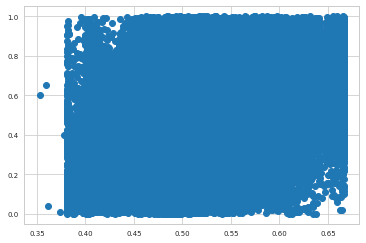

In [39]:
predictions_test = model_NN_Class.predict(X_test)
plt.plot(predictions_test.reshape(len(y_test)), y_test.reshape(len(y_test)),'o')

In [55]:

predictions_test.shape

(234378, 1)

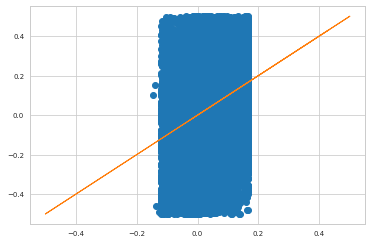

In [70]:
plt.plot(transform_predictand.inverse_transform(predictions_test), 
         transform_predictand.inverse_transform(y_test),'o')

plt.plot(transform_predictand.inverse_transform(y_test),transform_predictand.inverse_transform(y_test))

In [61]:
def Mutual_Information(x, y, bins):
    x = np.array(x).reshape(-1, 1)
    y = np.array(y).reshape(-1, 1)
    #print(len(x))
    discretizer_x = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    discretizer_y = KBinsDiscretizer(n_bins=bins, encode='ordinal', strategy='uniform')
    discretizer_x.fit(x)
    discretizer_y.fit(y)
    x_disc = discretizer_x.transform(x).reshape(len(x))
    y_disc = discretizer_y.transform(y).reshape(len(y))
    #print(x_disc)
    #print(y_disc)
    #plt.plot(x_disc)
    n_mi = normalized_mutual_info_score(x_disc, y_disc)
    mi = mutual_info_score(x_disc, y_disc)
    return n_mi, mi

In [62]:
predictor_array.shape

(534378, 106)

In [69]:
for i in range(99):
    print(i,Mutual_Information(np.percentile(predictor_array,i, axis=1),Predictand, 100))

0 (0.007628294451994415, 0.024770189766629556)
1 (0.006708863256697686, 0.020226734986031884)
2 (0.005360759392126659, 0.014995563812250416)
3 (0.004151920839481903, 0.010842289156711492)
4 (0.003262572609903484, 0.007959941349019785)
5 (0.0030920920328037257, 0.007268839142322279)
6 (0.0026240557993939817, 0.005866334948787921)
7 (0.002621252787364952, 0.005660684566745417)
8 (0.002131596965127934, 0.004488096900312036)
9 (0.001595599588505205, 0.003309688865302651)
10 (0.001076319479206645, 0.002215351556873545)
11 (0.0006870952722160109, 0.0014087051562427125)
12 (0.00041880293602681684, 0.0008572197518775677)
13 (0.00023824143669797947, 0.0004872675969185538)
14 (0.00010743743751865953, 0.00021966752217320327)
15 (4.539521657310624e-05, 9.280163647935904e-05)
16 (1.4774847009010145e-05, 3.0202871896420547e-05)
17 (4.0459504125757105e-06, 8.27051975531206e-06)
18 (4.0459504125757105e-06, 8.27051975531206e-06)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


19 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


20 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


21 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


22 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


23 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


24 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


25 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


26 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


27 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


28 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


29 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


30 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


31 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


32 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


33 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


34 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


35 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


36 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


37 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


38 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


39 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


40 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


41 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


42 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


43 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


44 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


45 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


46 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


47 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


48 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


49 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


50 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


51 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


52 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


53 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


54 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


55 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


56 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


57 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


58 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


59 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


60 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


61 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


62 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


63 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


64 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


65 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


66 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


67 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


68 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


69 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


70 (0.0, 0.0)


/home/cdsw/.local/lib/python3.6/site-packages/sklearn/preprocessing/_discretization.py:188: UserWarning: Feature 0 is constant and will be replaced with 0.
  "replaced with 0." % jj)


71 (0.0, 0.0)
72 (4.0459504125757105e-06, 8.27051975531206e-06)
73 (4.0459504125757105e-06, 8.27051975531206e-06)
74 (4.0459504125757105e-06, 8.27051975531206e-06)
75 (1.0255264518487773e-05, 2.0963410324093282e-05)
76 (1.3958306896898278e-05, 2.8533209923197517e-05)
77 (1.3958306896898278e-05, 2.8533209923197517e-05)
78 (1.8903137549218385e-05, 3.8641555802161936e-05)
79 (2.600469391093514e-05, 5.31591583924644e-05)
80 (4.482351621074234e-05, 9.163217366442346e-05)
81 (6.657604107905949e-05, 0.0001361050172657943)
82 (0.00010023370622813996, 0.00020493004276075905)
83 (0.00016369929536179102, 0.00033472954628459343)
84 (0.00023563087930008052, 0.0004819070816150187)
85 (0.00031238069175718226, 0.0006390704297645116)
86 (0.0004689457821780548, 0.0009599449164007001)
87 (0.0006883677175146035, 0.0014104803770699037)
88 (0.0009752160403860342, 0.002001741506706398)
89 (0.0013710479439661436, 0.0028242850335845277)
90 (0.001957009196716857, 0.004054451004024774)
91 (0.0023354421624284614,

In [68]:
np.percentile(predictor_array,i, axis=1).shape

(534378,)

In [67]:
Predictand.shape

(534378,)

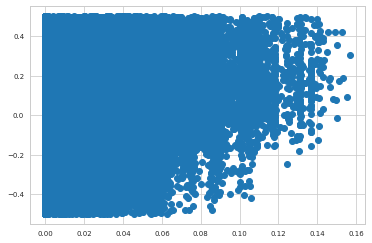

In [60]:
plt.plot(np.percentile(predictor_array,99, axis=0),Predictand,'o')

(array([[462., 477., 546., ..., 572., 543., 505.],
        [  0.,   0.,   0., ...,   0.,   2.,   2.],
        [  0.,   0.,   0., ...,   0.,   0.,   1.],
        ...,
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.],
        [  0.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.        , 0.00039921, 0.00079841, 0.00119762, 0.00159682,
        0.00199603, 0.00239523, 0.00279444, 0.00319365, 0.00359285,
        0.00399206, 0.00439126, 0.00479047, 0.00518968, 0.00558888,
        0.00598809, 0.00638729, 0.0067865 , 0.0071857 , 0.00758491,
        0.00798412, 0.00838332, 0.00878253, 0.00918173, 0.00958094,
        0.00998014, 0.01037935, 0.01077856, 0.01117776, 0.01157697,
        0.01197617, 0.01237538, 0.01277459, 0.01317379, 0.013573  ,
        0.0139722 , 0.01437141, 0.01477061, 0.01516982, 0.01556903,
        0.01596823, 0.01636744, 0.01676664, 0.01716585, 0.01756506,
        0.01796426, 0.01836347, 0.01876267, 0.01916188, 0.01956108,

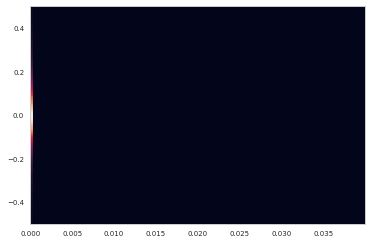

In [52]:
plt.hist2d(np.percentile(predictor_array,90, axis=1),Predictand,bins=100)

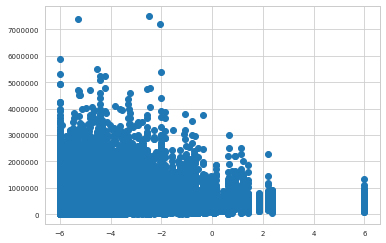

In [65]:
plt.plot(predictor_array_transformed[:,-2],Predictand,'o')

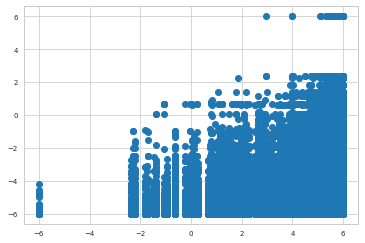

In [66]:
plt.plot(predictor_array_transformed[:,0],predictor_array_transformed[:,-2],'o')

In [30]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)